In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os



In [2]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.4 MB/s eta 0:00:00


In [4]:
!pip install tornado --upgrade

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [6]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')

In [7]:
data1 = pd.read_csv('../input/data-ethusdt/BINANCE_ETHUSDT 1D_b6140.csv')

In [8]:

stock_data = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/tsla.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)


In [9]:
stock_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-06-28,17.00,17.00,17.00,17.00,0,0
2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2010-06-30,25.79,30.42,23.30,23.83,17194394,0
2010-07-01,25.00,25.92,20.27,21.96,8229863,0
2010-07-02,23.00,23.10,18.71,19.20,5141807,0
...,...,...,...,...,...,...
2017-11-06,307.00,307.50,299.01,302.78,6482486,0
2017-11-07,301.02,306.50,300.03,306.05,5286320,0
2017-11-08,305.50,306.89,301.30,304.31,4725510,0


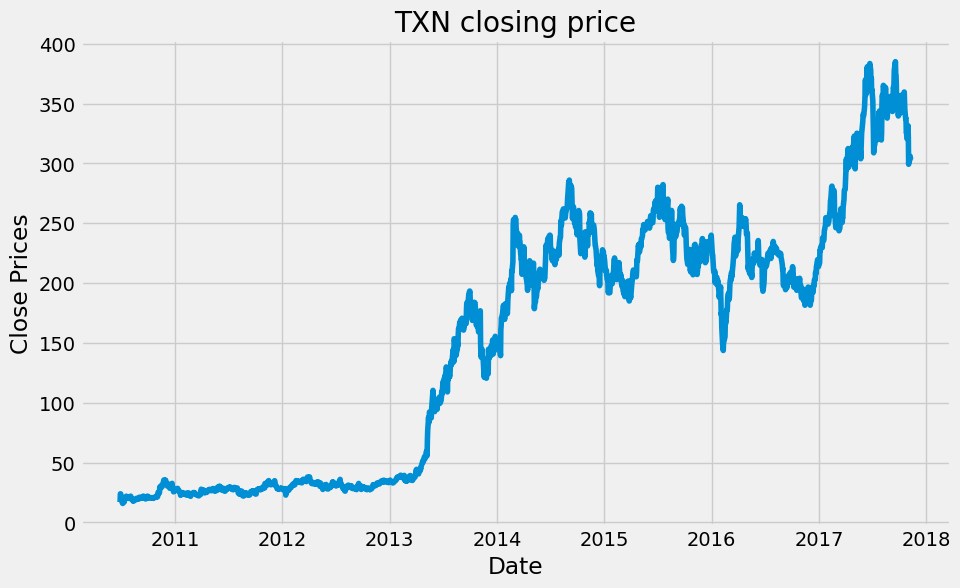

In [10]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('TXN closing price')
plt.show()

<Axes: ylabel='Density'>

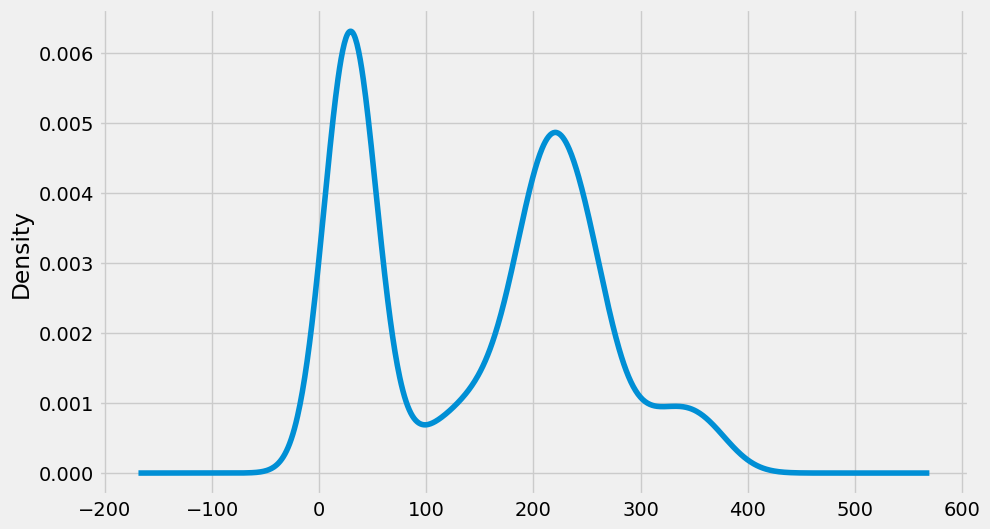

In [11]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

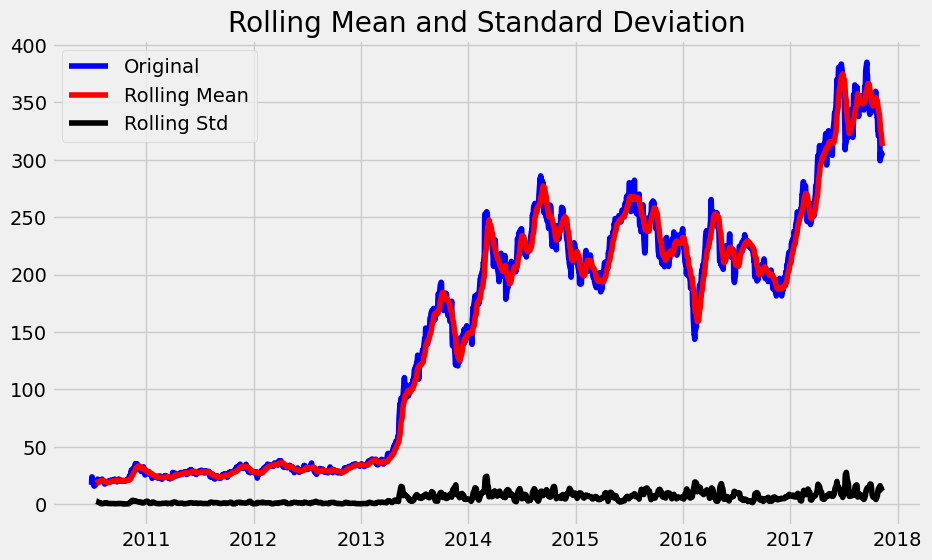

Results of dickey fuller test
Test Statistics                  -0.842866
p-value                           0.806205
No. of lags used                  1.000000
Number of observations used    1856.000000
critical value (1%)              -3.433878
critical value (5%)              -2.863099
critical value (10%)             -2.567600
dtype: float64


In [12]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

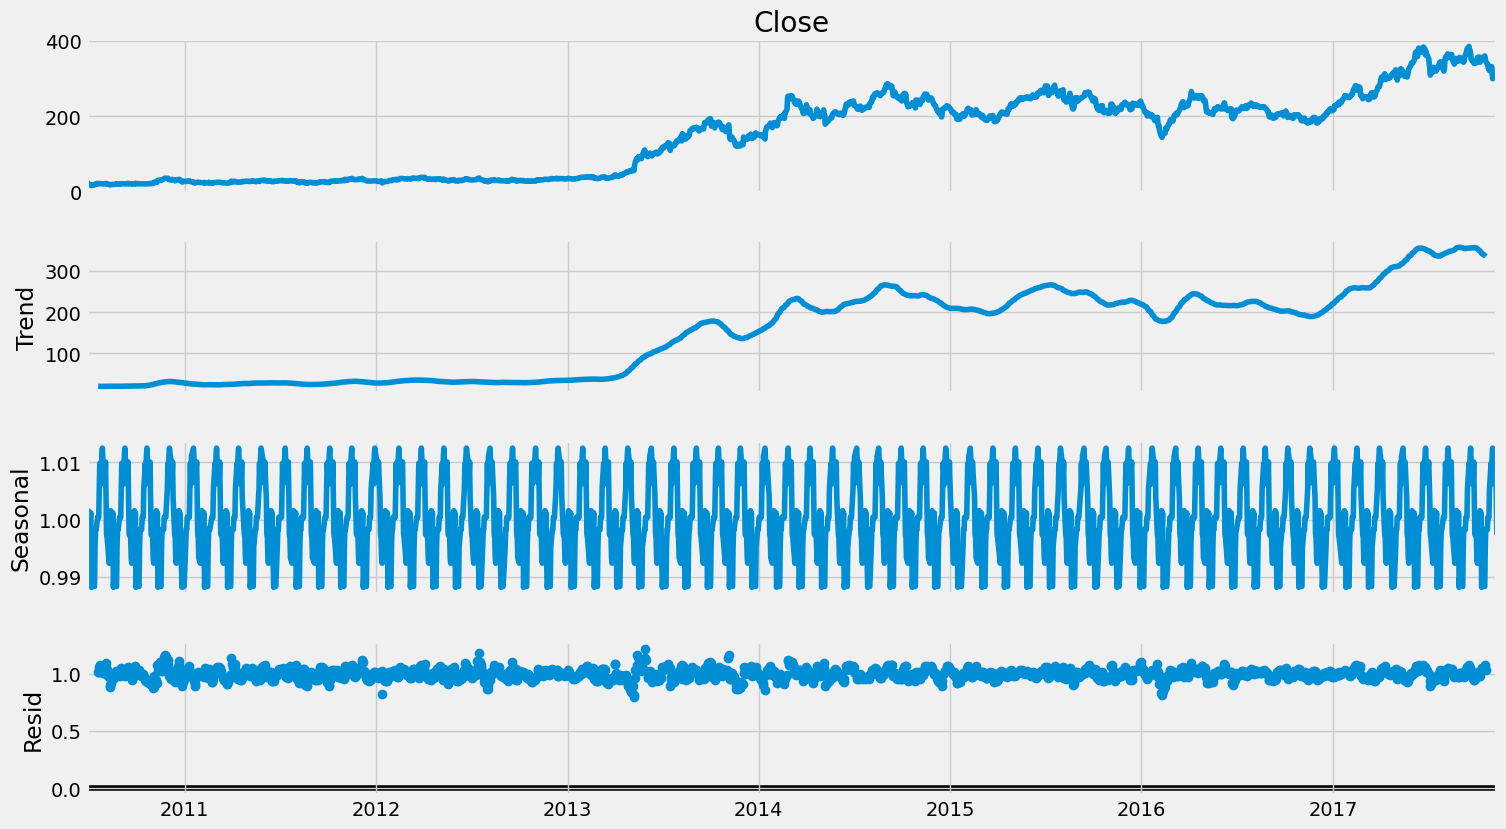

In [13]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

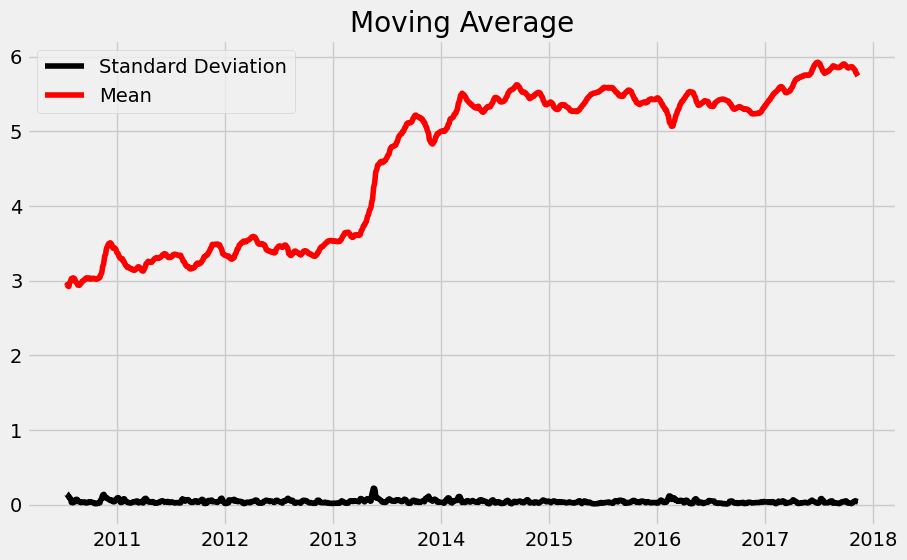

In [14]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

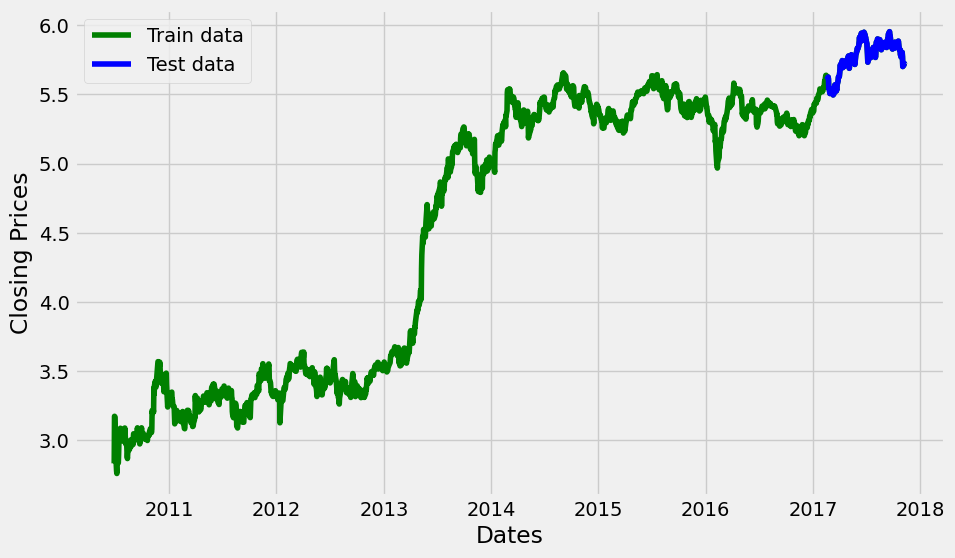

In [15]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


In [16]:
print( len(train_data))
print( len(test_data))


1669
186


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6664.451, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6662.798, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6662.836, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6662.953, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6660.426, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.720 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1669
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3334.226
Date:                Sun, 19 Nov 2023   AIC                          -6664.451
Time:                        02:45:54   BIC                          -6653.612
Sample:                             0   HQIC                         -6660.435
                               - 1669                                  

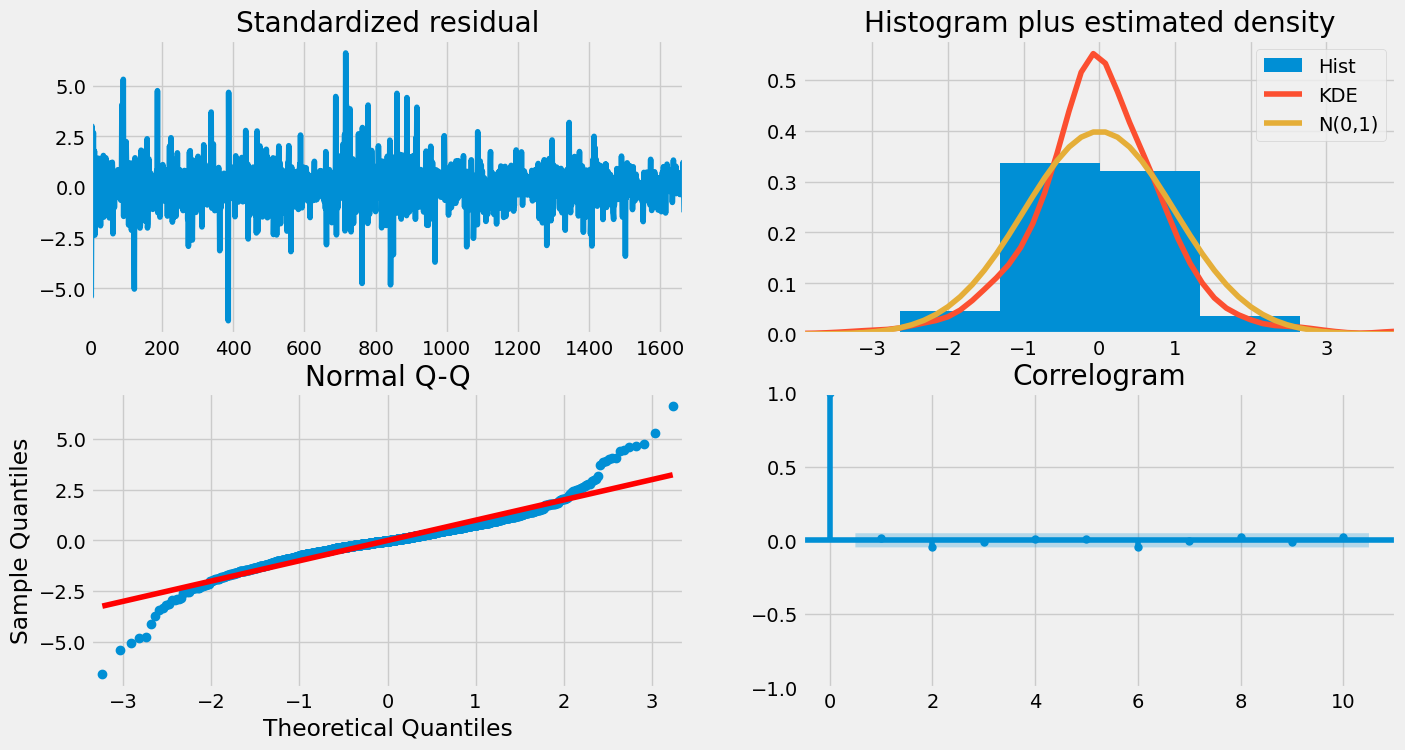

In [17]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [18]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1669
Model:                 ARIMA(1, 1, 2)   Log Likelihood                3334.540
Date:                Sun, 19 Nov 2023   AIC                          -6661.080
Time:                        02:45:57   BIC                          -6639.403
Sample:                             0   HQIC                         -6653.048
                               - 1669                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1703      0.435      0.392      0.695      -0.681       1.022
ma.L1         -0.1540      0.436     -0.353      0.724      -1.008       0.700
ma.L2         -0.0491      0.019     -2.546      0.0

In [19]:
forecast_result = fitted.forecast(186, alpha=0.05)
print(forecast_result)


1669    5.593933
1670    5.595747
1671    5.596056
1672    5.596109
1673    5.596118
          ...   
1850    5.596119
1851    5.596119
1852    5.596119
1853    5.596119
1854    5.596119
Name: predicted_mean, Length: 186, dtype: float64


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [20]:
forecast_result = fitted.get_forecast(steps=186)
predicted_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
fc = forecast_result.predicted_mean
se = forecast_result.se_mean
conf = forecast_result.conf_int(alpha=0.05)

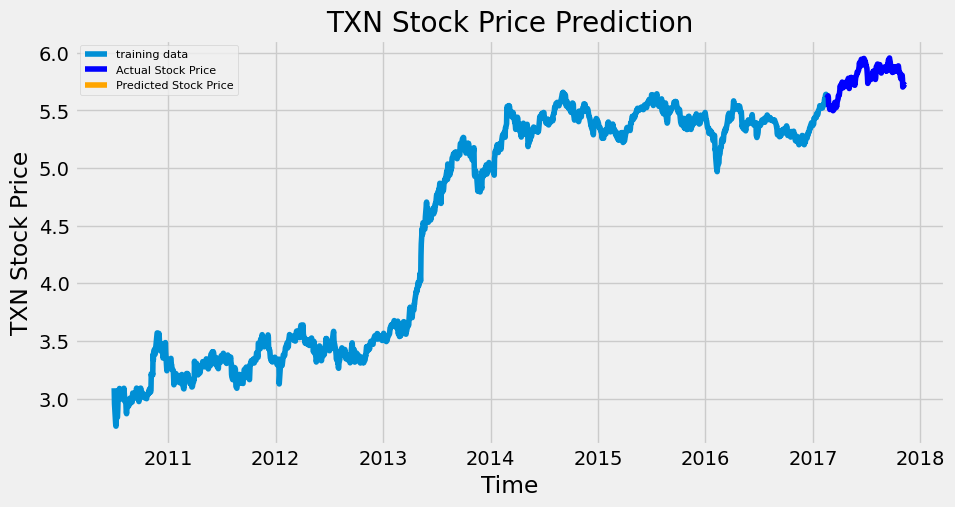

In [22]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('TXN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TXN Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
print(len(fc), len(test_data))

186 186


In [24]:
print(fc.isna().any())
print(test_data.isna().any())


False
False


In [25]:
fc_filled = fc.fillna(method='ffill')  # 向前填充
test_data = test_data.fillna(method='ffill')


In [26]:

# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: ' + str(mse))

mae = mean_absolute_error(test_data, fc)
print('MAE: ' + str(mae))

rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ' + str(rmse))

# 确保 fc 和 test_data_aligned 长度相同
fc_aligned = fc[:len(test_data)]

# 创建一个布尔数组，标识非零值
non_zero = test_data != 0

# 使用位置索引计算 MAPE
mape_values = np.abs((fc_aligned[non_zero.values] - test_data[non_zero.values]) / test_data[non_zero.values])

# 计算 MAPE
mape = np.mean(mape_values)
print('MAPE: ' + str(mape))



MSE: 0.04639167422097878
MAE: 0.19512316978709157
RMSE: 0.21538726568898817
MAPE: nan
